<a href="https://colab.research.google.com/github/yashpatil454/Deep_Audio_Classifier_Convolutinal_NN/blob/main/Deep_Audio_Classifier_Convolutional_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashpatil454","key":"e4f700df75f92a9ab4281ff6cbc9a747"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#Downloading dataset from Kaggle
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

 98% 589M/604M [00:06<00:00, 81.5MB/s]
100% 604M/604M [00:06<00:00, 99.0MB/s]


In [4]:
!unzip -q /content/z-by-hp-unlocked-challenge-3-signal-processing.zip

In [5]:
#Importing required libraries
!pip install tensorflow-io
import os
import csv
from matplotlib import pyplot as plt
import numpy as np
from itertools import groupby
from IPython.display import Audio
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 37.0 MB/s eta 0:00:00


##Data loading and Preprocessing of the audio function

In [6]:
CAPUCHIN_FILE = os.path.join('Parsed_Capuchinbird_Clips', 'XC3776-6.wav')
NOT_CAPUCHIN_FILE = os.path.join('Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-10.wav')

In [7]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [8]:
load_wav_16k_mono(CAPUCHIN_FILE)

<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([-3.3910814e-07,  1.0247953e-06, -1.3469314e-06, ...,
       -3.0875366e-02,  3.8422588e-02,  4.3280780e-02], dtype=float32)>

##Visualizing decode wav data

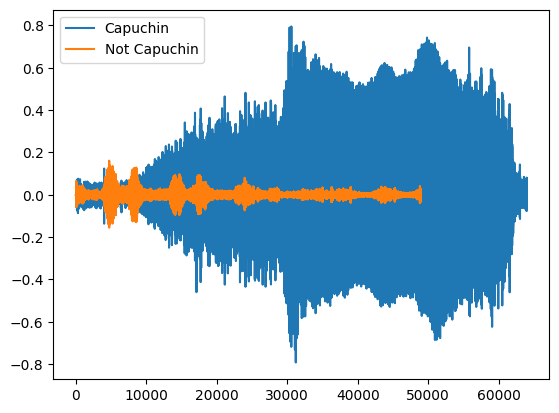

In [9]:
# Load and plot the first waveform
wav_capuchin = load_wav_16k_mono(CAPUCHIN_FILE)
plt.plot(wav_capuchin, label='Capuchin')

# Load and plot the second waveform
wav_not_capuchin = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
plt.plot(wav_not_capuchin, label='Not Capuchin')

# Add legend and show
plt.legend()
plt.show()

In [10]:
#Listening to a sample .wav file
Audio(CAPUCHIN_FILE)

##Creating TF datasets and adding labels

In [11]:
pos = tf.data.Dataset.list_files(os.path.join('Parsed_Capuchinbird_Clips', '*.wav'))
neg = tf.data.Dataset.list_files(os.path.join('Parsed_Not_Capuchinbird_Clips', '*.wav'))

In [12]:
positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives).shuffle(1000)

In [13]:
#Time duration of .wav files
time_duration = []
for file in os.listdir(os.path.join('Parsed_Capuchinbird_Clips')):
  tensor_wav = load_wav_16k_mono(os.path.join('Parsed_Capuchinbird_Clips', file))
  time_duration.append(round(len(tensor_wav)/16000,2))

In [14]:
print(f'Mean time duration of .wav file:',tf.math.reduce_mean(time_duration).numpy())
print(f'Min. time duration of .wav file:',tf.math.reduce_min(time_duration).numpy())
print(f'Max. time duration of .wav file:',tf.math.reduce_max(time_duration).numpy())

Mean time duration of .wav file: 3.3847926
Min. time duration of .wav file: 2.0
Max. time duration of .wav file: 5.0


Note: Looking at the time duration of .wav file we will consider 3 seconds time frame for training our CNN model. **3 secs X 16000 samples/second = 48000 samples**

##Preprocessing function to convert to spectogram

In [15]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [16]:
# Visualizing the spectogram for one positive sample.
filepath, label = positives.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

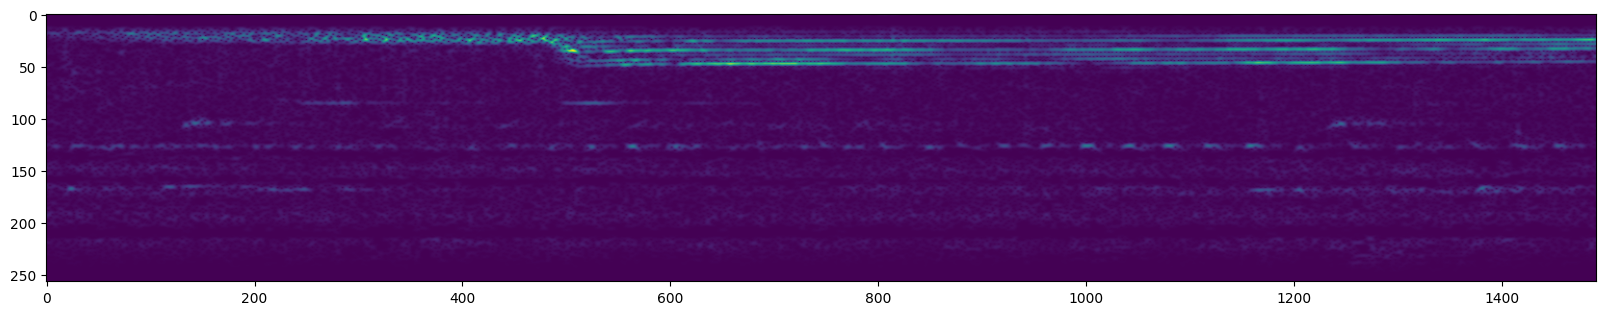

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(tf.transpose(spectrogram)[0])

In [18]:
# Visualizing the spectogram for one negative sample.
filepath, label = negatives.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

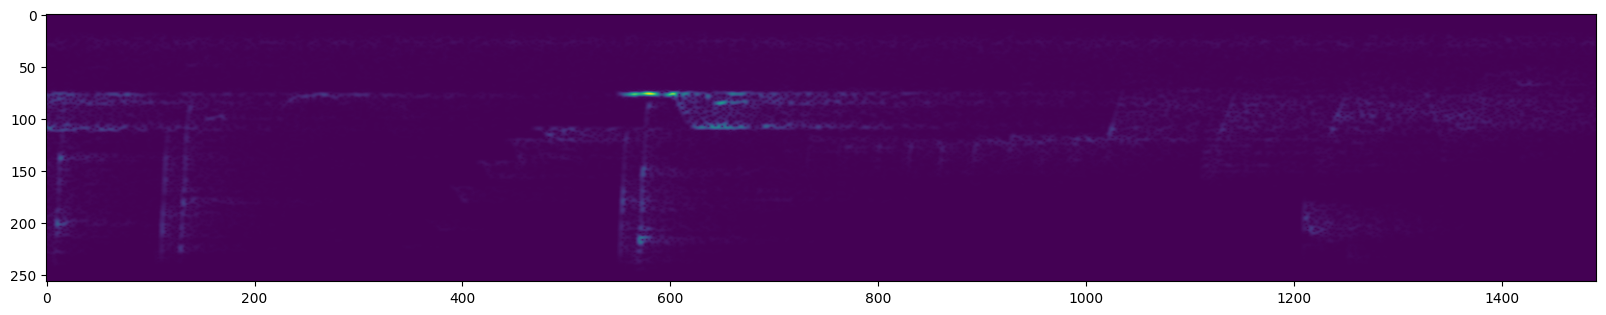

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(tf.transpose(spectrogram)[0])

## Creating a Tensorflow data pipeline

In [20]:
data = data.map(preprocess).cache().shuffle(buffer_size=1000).batch(8).prefetch(4)

In [21]:
samples, labels = data.as_numpy_iterator().next()
samples.shape

(8, 1491, 257, 1)

In [22]:
len(data)

102

Note: We will take 70% of data for training and 30% for testing.

## Splitting data into train and test

In [23]:
train = data.take(74)
test = data.skip(74).take(28)

##Building Deep learning model

In [24]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 128)               385240192 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 385,240,985
Trainable params: 385,240,985
Non-trainable params: 0
_________________________________________________________________


## Fit Model, View Loss and KPI Plots

In [27]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
74/74 [==============================] - 21s 126ms/step - loss: 1.0029 - recall: 0.9200 - precision: 0.8734 - val_loss: 0.0389 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/4
74/74 [==============================] - 9s 128ms/step - loss: 0.0381 - recall: 0.9815 - precision: 0.9937 - val_loss: 0.0996 - val_recall: 0.9286 - val_precision: 1.0000
Epoch 3/4
74/74 [==============================] - 9s 120ms/step - loss: 0.0619 - recall: 0.9804 - precision: 0.9677 - val_loss: 0.0396 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
74/74 [==============================] - 9s 121ms/step - loss: 0.0249 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0047 - val_recall: 1.0000 - val_precision: 1.0000


In [28]:
hist.history

{'loss': [1.002898097038269,
  0.03805600479245186,
  0.06188857927918434,
  0.024872923269867897],
 'recall': [0.9200000166893005, 0.9814814925193787, 0.9803921580314636, 1.0],
 'precision': [0.8734177350997925,
  0.9937499761581421,
  0.9677419066429138,
  1.0],
 'val_loss': [0.03894397243857384,
  0.09956399351358414,
  0.03962613642215729,
  0.004676319658756256],
 'val_recall': [1.0, 0.9285714030265808, 1.0, 1.0],
 'val_precision': [1.0, 1.0, 1.0, 1.0]}

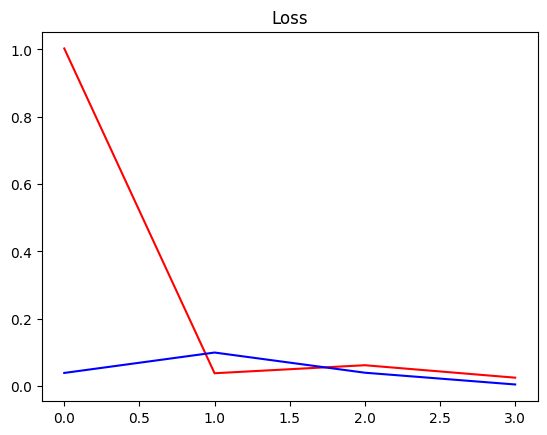

In [29]:
#Plotting historical data of the fit.
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

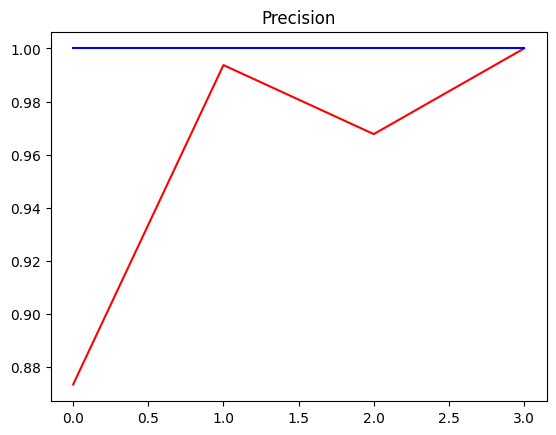

In [30]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

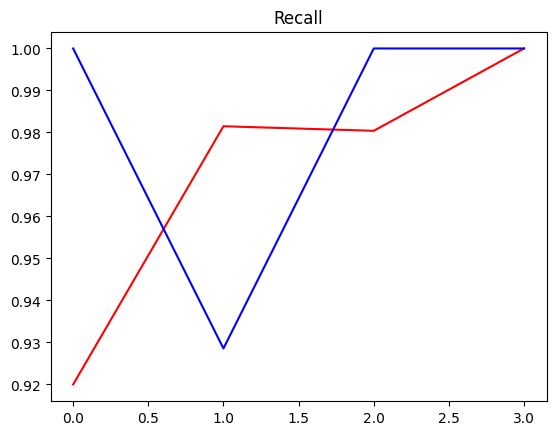

In [31]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [32]:
# Making prediction on a sample clip
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

1/1 [==============================] - 0s 101ms/step


In [33]:
#converting predicted output to o and 1 binary output
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
print(yhat)
print(y_test)

[0, 0, 0, 1, 1, 0, 1, 0]
[0. 0. 0. 1. 1. 0. 1. 0.]


##Building Forest Audio parsing function

In [34]:
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [35]:
wav = load_mp3_16k_mono(os.path.join('Forest Recordings', 'recording_00.mp3'))
print(wav)

tf.Tensor(
[ 8.1433272e-12 -5.7019250e-12 -5.3486417e-12 ... -1.1291276e-02
 -1.4230422e-02 -3.0555837e-03], shape=(2880666,), dtype=float32)


In [36]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()

In [37]:
print(len(audio_slices))

60


In [38]:
print(samples,"/", index)

[[ 8.1433272e-12 -5.7019250e-12 -5.3486417e-12 ...  6.2619494e-03
  -1.5455363e-02 -8.7941047e-03]] / [8.143327e-12]


In [39]:
print(len(samples[0]))

48000


##Spectogram of mp3 audio file

In [40]:
def preprocess_mp3(samples, index):
    wav = samples[0]
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [41]:
# Visualizing the spectogram for one positive sample.
spectrogram = preprocess_mp3(samples, index)

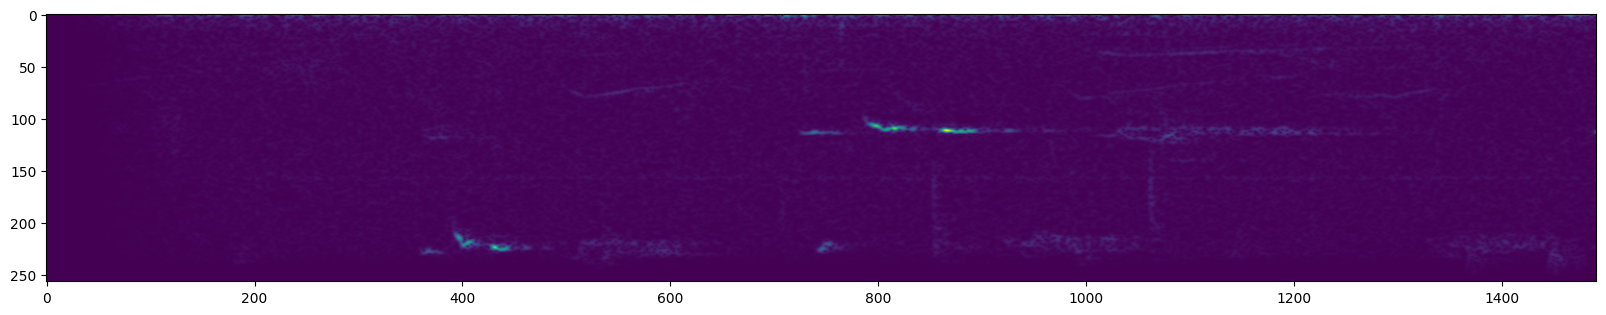

In [42]:
plt.figure(figsize=(20,20))
plt.imshow(tf.transpose(spectrogram)[0])

##Converting simple mp3 audio clips into windows and making predictions

In [43]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [44]:
yhat = model.predict(audio_slices)
#converting predicted output to o and 1 binary output
yhat = [1 if prediction > 0.9 else 0 for prediction in yhat]

1/1 [==============================] - 3s 3s/step


In [45]:
# Converting continous occuring calls as one observation.
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls

8

##Making predictions on all mp3 recordings

In [46]:
res = {}
for file in os.listdir('Forest Recordings'):
    FILEPATH = os.path.join('Forest Recordings', file)
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)
    res[file] = yhat

1/1 [==============================] - 1s 1s/step


In [47]:
preds = {}
for file, logits in res.items():
    yhat = [1 if prediction > 0.99 else 0 for prediction in logits]
    yhat = [key for key, group in groupby(yhat)]
    calls = tf.math.reduce_sum(yhat).numpy()
    preds[file] = calls

preds

{'recording_56.mp3': 2,
 'recording_01.mp3': 0,
 'recording_11.mp3': 7,
 'recording_51.mp3': 7,
 'recording_82.mp3': 0,
 'recording_07.mp3': 2,
 'recording_98.mp3': 14,
 'recording_66.mp3': 0,
 'recording_16.mp3': 8,
 'recording_53.mp3': 0,
 'recording_35.mp3': 0,
 'recording_04.mp3': 8,
 'recording_18.mp3': 8,
 'recording_61.mp3': 1,
 'recording_41.mp3': 0,
 'recording_92.mp3': 6,
 'recording_94.mp3': 3,
 'recording_60.mp3': 5,
 'recording_17.mp3': 1,
 'recording_77.mp3': 1,
 'recording_21.mp3': 1,
 'recording_74.mp3': 0,
 'recording_50.mp3': 0,
 'recording_87.mp3': 16,
 'recording_24.mp3': 0,
 'recording_44.mp3': 1,
 'recording_96.mp3': 1,
 'recording_14.mp3': 0,
 'recording_31.mp3': 1,
 'recording_33.mp3': 0,
 'recording_70.mp3': 4,
 'recording_88.mp3': 0,
 'recording_90.mp3': 0,
 'recording_76.mp3': 0,
 'recording_34.mp3': 4,
 'recording_65.mp3': 5,
 'recording_83.mp3': 0,
 'recording_78.mp3': 1,
 'recording_32.mp3': 1,
 'recording_09.mp3': 0,
 'recording_27.mp3': 0,
 'recording_85

##Exporting results

In [49]:
#Adding results to csv file
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in preds.items():
        writer.writerow([key, value])